# **Introducción al Quantum Machine Learning 3**
*Universidad Nacional Autónoma de México*

## Laboratorio Avanzado de Procesamiento de Imágenes

### Autor: **Sebastián González Juárez**

Académicos:
* Dra. Jimena Olveres Montiel
* Dr. Boris Escalante Ramírez
* Naomi Itzel Reyes Granados

Temas Selectos de Ingenieria III - **Introducción a la computación cuántica**.

Este ipynb agrega la posibilidad de utilizarlo con Google Colab sin necesidad de instalar nada sus computadoras.

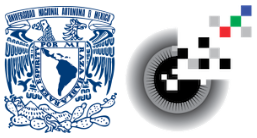

# **3. Procesamiento de imágenes con PennyLane y PyTorch**

**Meta**

Construir una QNN desde 0 que procese imágenes del conjunto Digits, en este caso por tiempo y por simplificar reduciremos la imágen y trabajaremos con clasificación binaria.

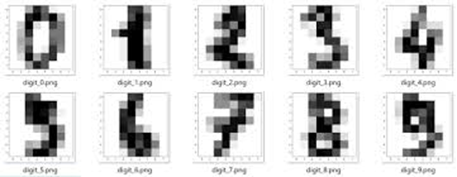

Recordemos que un VQA es un algoritmo cuántico híbrido que combina un circuito cuántico parametrizado con un optimizador clásico para minimizar la función de costo. Lo podemos dividir en 4 secciones, explicadas resumidamente a continuación:

  1)	Feature Map: Su función es codificar los datos clásicos a estados cuánticos, utilizamos compuertas cuánticas que permitan una superposición de los qubits.

  2)	Variational Quantum Circuit: Este es el núcleo del modelo cuántico, cuenta con un conjunto de compuertas dependientes de parámetros ajustables los cuales vamos a entrenar. Además, tendrá compuertas de control que tengan como objetivo entrelazar nuestros qubits. Estos dos conjuntos los podemos repetir varias veces para darle profundidad al circuito.
  
  3)	Measurement: Este bloque da final a la parte cuántica, en la cual medimos los estados de los qubits para obtener valores clásicos probabilistas como lo son las expectativas, estas salidas son el valor esperado de un observable y con lo que armaremos nuestra función de costo.
  
  4)	Classical Model: En esta sección evaluaremos la función de costo y utilizaremos un optimizador clásico para ajustar los parámetros minimizando, en esta sección se trabaja con una red neuronal clásica.


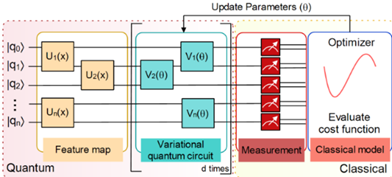

Este código busca implementar GPU, pero se pueden realizar versiones más sencillas con solo CPU.

In [34]:
!pip -q install "pennylane>=0.43" "pennylane-lightning[gpu]>=0.43" scikit-learn --upgrade
!nvidia-smi -L || true

import math, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score

import pennylane as qml

GPU 0: Tesla T4 (UUID: GPU-2b06ceb8-1753-63ed-cb8e-19e267e3ffad)


## 3.1. Configuración reproducible + Hiperparámetros:

In [35]:
SEED = 87                                              # Semilla global para reproducibilidad
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)  # Fija la semilla en Python, NumPy y PyTorch

assert torch.cuda.is_available(), "Activa GPU en Colab (Entorno de ejecución > Cambiar tipo > GPU)."  # Verifica que haya GPU disponible
DEVICE = torch.device("cuda")                          # Selecciona el dispositivo CUDA
print("[OK] PyTorch en", DEVICE, "-", torch.cuda.get_device_name(0))  # Imprime nombre de la GPU activa

BATCH_SIZE   = 32                                      # Tamaño de lote para el DataLoader
EPOCHS       = 15                                      # Número de épocas de entrenamiento
LR           = 3e-2                                    # Tasa de aprendizaje para Adam
DROPOUT_P    = 0.30                                    # Probabilidad de dropout en la cabeza clásica

QUBITS       = 4                                       # Número de qubits del circuito VQA
LAYERS       = 4                                       # Capas (bloques variacionales) del ansatz
DIFF_METHOD  = "parameter-shift"                       # Método de diferenciación para obtener gradientes del QNode
SHOTS        = 1000                                    # Número de mediciones (muestreos) por evaluación del circuito

[OK] PyTorch en cuda - Tesla T4


## 3.2. Datos y Reducción: Digits 8x8 -> 2x2 (avg-pool 4x4) -> 4 features

In [36]:
CLASS_A, CLASS_B = 1, 0                                                # Clases elegidas para binarizar (A contra B)
print(f"Clasificación binaria: {CLASS_A} vs {CLASS_B}")                # Mensaje informativo de qué pares se usarán

digits = load_digits()                                                 # Carga Digits (1797 imágenes 8×8) desde sklearn
X = torch.from_numpy(digits.images.astype(np.float32)).unsqueeze(1) / 16.0  # Convierte a tensor, agrega canal (N,1,8,8) y normaliza a [0,1]
y = torch.from_numpy(digits.target.astype(np.int64))                  # Etiquetas originales (0–9) como tensor long

# Filtramos solo las clases deseadas
mask = (y == CLASS_A) | (y == CLASS_B)                                # Máscara booleana para A o B
X, y = X[mask], y[mask]                                               # Subconjunto con solo esas dos clases
y = (y == CLASS_B).long()                                             # Remapea: clase B → 1, clase A → 0

# Reducimos 8×8 → 2×2 (avg-pool 4×4)
X = F.avg_pool2d(X, kernel_size=4, stride=4).view(-1, 4)              # Promedia bloques 4×4 y aplana a 4 features por imagen (N,4)

# Split 60/20/20
N = X.shape[0]                                                         # Número total de muestras tras el filtro
n_tr = int(0.6*N); n_va = int(0.2*N); n_te = N - n_tr - n_va           # Tamaños de train/val/test
ds_all = TensorDataset(X, y)                                           # Dataset tensorial (features, etiqueta)
train_set, val_set, test_set = random_split(                           # Partición reproducible con la semilla global
    ds_all, [n_tr, n_va, n_te],
    generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)   # Loader de entrenamiento (baraja)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)   # Loader de validación (sin barajar)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)   # Loader de prueba (sin barajar)

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")               # Muestra tamaños finales por split

Clasificación binaria: 1 vs 0
Train: 216 | Val: 72 | Test: 72


## 3.3. Dispositivo cuántico (GPU interna) + QNode tensor.

1) **Configuración del backend cuántico (`dev = qml.device(...)`)**  
   Crea el dispositivo cuántico que usará PennyLane — en este caso `lightning.gpu`, que ejecuta el circuito en GPU (cuQuantum).  
   Define el número de qubits (`QUBITS`) y de mediciones o *shots* (`SHOTS`) por ejecución.

Obs. Si buscamos trabajar con CPU, podemos usar default.qubit (Buen simulador para pocos qubits) o lightning.qubit (Pierde formalidad a comparación del default, pero es mucho más rápido y es recoendable muchos de qubits).

In [37]:
dev = qml.device("lightning.gpu", wires=QUBITS, shots=SHOTS)                      # Crea el backend cuántico en GPU (cuQuantum), con QUBITS hilos y SHOTS mediciones

/usr/local/lib/python3.12/dist-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


2) **Definición del circuito cuántico (`@qml.qnode(...) def qnode(...)`)**  
   Implementa el circuito variacional:  
   - Codifica las 4 features de entrada con rotaciones `RY`.  
   - Aplica `LAYERS` bloques compuestos de rotaciones parametrizadas `RY/RZ` y una capa de compuertas `CNOT` en anillo (0→1→2→3→0).  
   - Devuelve el vector de probabilidades (`qml.probs`) de tamaño 16 correspondiente a los estados base de los 4 qubits.

   $$p(|0000⟩), p(|0001⟩), p(|0010⟩), ..., p(|1111⟩)$$


In [38]:
@qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)                       # Declara un QNode (circuito diferenciable) con interfaz Torch y gradiente por parameter-shift
def qnode(phi, weights):                                                           # phi: (4,) ángulos de entrada; weights: (LAYERS,QUBITS,2) parámetros variacionales
    for w in range(QUBITS):                                                        # Embedding de datos
        qml.RY(phi[w], wires=w)                                                    # Codifica cada feature en rotaciones RY sobre cada qubit
    for l in range(LAYERS):                                                        # Repite el bloque variacional LAYERS veces
        for w in range(QUBITS):                                                    # Parte local por qubit
            qml.RY(weights[l, w, 0], wires=w)                                      # Rotación RY parametrizada (primer parámetro)
            qml.RZ(weights[l, w, 1], wires=w)                                      # Rotación RZ parametrizada (segundo parámetro)
        qml.CNOT([0,1]); qml.CNOT([1,2]); qml.CNOT([2,3]); qml.CNOT([3,0])         # Entrelazamiento en anillo: 0→1→2→3→0
    return qml.probs(wires=range(QUBITS))                                          # Devuelve vector de probabilidades (2^QUBITS = 16), tensor Torch float64

Imagen ilustrativa del VQA en Qiskit con 2 capas (estamos trabajando con 4):

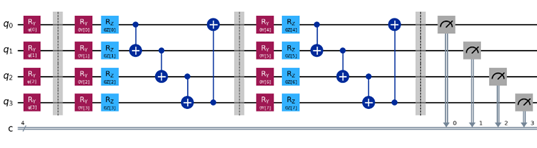

3) **Capa cuántica como módulo de PyTorch (`class QLayer(nn.Module)`)**  
   Envuelve el QNode para integrarlo con redes clásicas:  
   - Define los parámetros entrenables `theta` en CPU (float64).  
   - Convierte las entradas `(B,4)` a ángulos (`φ = πx`), ejecuta el circuito muestra por muestra y obtiene las probabilidades.  
   - Devuelve un tensor `(B,16)` en float32 listo para pasar a la cabeza clásica que opera en GPU.

In [39]:
class QLayer(nn.Module):                                                           # Capa PyTorch que envuelve al QNode para usarlo dentro del modelo
    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(LAYERS, QUBITS, 2,                   # Parámetros variacionales del circuito
                                              dtype=torch.float64))                # Se mantienen en CPU y en float64 (estable para PL)
    def forward(self, x_cpu_f32):                                                  # x_cpu_f32: batch (B,4) en CPU y float32
        phis = (math.pi * x_cpu_f32.to(dtype=torch.float64))                       # Escala a [0,π] y castea a float64 (lo que espera el QNode)
        outs = []                                                                  # Acumulará las salidas del QNode por muestra
        for b in range(phis.shape[0]):                                             # Itera sobre el batch (evaluación por muestra)
            probs64 = qnode(phis[b], self.theta)                                   # Ejecuta el circuito: obtiene probs (16,) float64 CPU
            outs.append(probs64.to(dtype=torch.float32))                           # Convierte a float32 para casar con la cabeza en CUDA
        return torch.stack(outs, dim=0)                                            # Apila a (B,16) float32 CPU (luego se moverá a GPU en el modelo)

**Tipos de medición en PennyLane**

- **`qml.probs()`** → medición en la **base computacional**, devuelve las **probabilidades esperadas** de cada estado base.  
  - Salida: **valores continuos** entre 0 y 1 que suman 1.  
  - Ejemplo: `[0.05, 0.10, 0.25, 0.60]`  
  - Ideal para entrenamiento porque es **diferenciable**.

---

- **`qml.expval(qml.PauliZ(0))`** → devuelve una **expectación (valor medio)** del observable Pauli-Z sobre el qubit 0.  
  - Salida: **valor continuo** en el rango **[-1, +1]**.  
  - Representa la “polarización promedio” del qubit.

---

- **`qml.sample(qml.PauliZ(0))`** → realiza **mediciones discretas** (colapsos) del qubit 0 según los *shots* definidos.  
  - Salida: una lista de **0 o 1 (ó ±1)** por cada *shot*.  
  - Ejemplo con `shots=5`: `[1, -1, 1, 1, -1]`  
  - Útil para simulaciones de mediciones reales, pero **no diferenciable**, por eso no se usa al entrenar modelos cuánticos-clásicos.


## 3.4. Modelo híbrido: QLayer (CPU) -> mover a CUDA -> MLP (CUDA).

In [40]:
class HQBinary(nn.Module):                                                         # Define un modelo híbrido (cuántico + clásico) para clasificación binaria
    def __init__(self, p_dropout=DROPOUT_P):                                       # Constructor con dropout configurable
        super().__init__()                                                         # Inicializa la superclase nn.Module
        self.q = QLayer()  # CPU                                                   # Capa cuántica (QNode envuelto); parámetros e inputs en CPU
        self.head = nn.Sequential(                                                 # Cabeza clásica (MLP) que corre en CUDA
            nn.Linear(16, 64), nn.ReLU(),                                          # Proyección de 16 (probs de 4 qubits) a 64 + activación ReLU
            nn.Dropout(p_dropout),                                                 # Dropout para regularizar
            nn.Linear(64, 1)  # salida binaria (logit)                             # Capa final: 1 logit (antes de sigmoide)
        )
    def forward(self, x_cpu):                                                      # x_cpu: batch (B,4) en CPU (float32)
        zq_cpu  = self.q(x_cpu)                                                    # Ejecuta el circuito: obtiene embedding cuántico (B,16) en CPU
        zq_cuda = zq_cpu.to(device=DEVICE)                                         # Mueve el embedding a GPU para la cabeza clásica
        return self.head(zq_cuda).view(-1)                                         # Pasa por la MLP y aplana a (B,) logits

model = HQBinary()                                                                 # Instancia el modelo híbrido
model.head.to(DEVICE)                                                              # Mueve solo la cabeza clásica (MLP) a GPU
criterion = nn.BCEWithLogitsLoss().to(DEVICE)                                      # Función de pérdida binaria (combina sigmoide + BCE) en GPU
optim = torch.optim.Adam(model.parameters(), lr=LR)                                # Optimizador Adam para parámetros cuánticos y clásicos

model.q.theta.data = model.q.theta.data.cpu()                                      # Asegura que los parámetros cuánticos (theta) permanezcan en CPU


## 3.5. Entrenamiento + Validación.

In [41]:
def run_epoch(loader, train=False):                                                # Ejecuta una época completa (entrenamiento o validación)
    model.train(mode=train)                                                        # Activa o desactiva dropout y gradientes según train=True/False
    total_loss, total_correct, total_count = 0.0, 0, 0                             # Inicializa acumuladores para pérdida, aciertos y muestras
    all_y, all_s = [], []                                                          # Listas para guardar etiquetas y puntajes (sigmoide) de todas las muestras

    for xb, yb in loader:                                                          # Itera sobre los lotes del DataLoader
        yb = yb.to(DEVICE)                                                         # Mueve las etiquetas a GPU
        if train: optim.zero_grad(set_to_none=True)                                # Limpia gradientes antes del paso de optimización (solo si train=True)

        logits = model(xb)                                                         # Forward completo: QLayer (CPU) → embedding (B,16) → MLP (CUDA)
        loss = criterion(logits, yb.float())                                       # Calcula la pérdida binaria (BCE con logits)

        if train:                                                                  # Solo en entrenamiento:
            loss.backward()                                                        # Calcula gradientes (cuánticos + clásicos)
            optim.step()                                                           # Actualiza los parámetros del modelo

        total_loss += loss.item() * xb.size(0)                                     # Acumula pérdida ponderada por tamaño del batch
        preds = (torch.sigmoid(logits) > 0.5).long()                               # Convierte logits a predicciones binarias (umbral 0.5)
        total_correct += (preds == yb).sum().item()                                # Suma los aciertos de este lote
        total_count   += xb.size(0)                                                # Suma total de muestras procesadas

        all_y.append(yb.cpu())                                                     # Guarda etiquetas verdaderas en CPU
        all_s.append(torch.sigmoid(logits).detach().cpu())                         # Guarda probabilidades predichas (sigmoide aplicada)

    # Devuelve métricas promedio y tensores completos de etiquetas/probabilidades
    return (total_loss / total_count,                                              # Pérdida promedio por muestra
            total_correct / total_count,                                           # Accuracy promedio
            torch.cat(all_y), torch.cat(all_s))                                    # Etiquetas y scores concatenados


Tarda menos de 15 minutos.

In [42]:
# Bucle principal de entrenamiento/validación
tr_losses, va_losses, tr_accs, va_accs = [], [], [], []                            # Listas para registrar métricas por época
print("\n==> Entrenamiento binario")
for ep in range(1, EPOCHS+1):                                                      # Itera por cada época
    tr_l, tr_a, _, _ = run_epoch(train_loader, train=True)                         # Ejecuta entrenamiento en el conjunto train
    va_l, va_a, _, _ = run_epoch(val_loader,   train=False)                        # Evalúa rendimiento en validación (sin gradientes)
    tr_losses.append(tr_l); va_losses.append(va_l)                                 # Guarda pérdidas
    tr_accs.append(tr_a);  va_accs.append(va_a)                                    # Guarda accuracies
    print(f"Ep {ep:02d}/{EPOCHS} | train loss {tr_l:.4f} acc {tr_a*100:5.1f}% || " # Imprime resumen de la época
          f"val loss {va_l:.4f} acc {va_a*100:5.1f}%")



==> Entrenamiento binario
Ep 01/15 | train loss 0.6915 acc  54.6% || val loss 0.6918 acc  52.8%
Ep 02/15 | train loss 0.6552 acc  68.1% || val loss 0.6647 acc  63.9%
Ep 03/15 | train loss 0.6168 acc  69.0% || val loss 0.6640 acc  58.3%
Ep 04/15 | train loss 0.5813 acc  69.9% || val loss 0.6128 acc  65.3%
Ep 05/15 | train loss 0.5658 acc  69.9% || val loss 0.6063 acc  63.9%
Ep 06/15 | train loss 0.5023 acc  77.8% || val loss 0.5514 acc  72.2%
Ep 07/15 | train loss 0.4723 acc  78.7% || val loss 0.5243 acc  72.2%
Ep 08/15 | train loss 0.4551 acc  81.0% || val loss 0.4506 acc  79.2%
Ep 09/15 | train loss 0.4235 acc  81.0% || val loss 0.4212 acc  83.3%
Ep 10/15 | train loss 0.4300 acc  82.4% || val loss 0.4503 acc  77.8%
Ep 11/15 | train loss 0.3867 acc  83.8% || val loss 0.4582 acc  77.8%
Ep 12/15 | train loss 0.4075 acc  80.6% || val loss 0.5556 acc  69.4%
Ep 13/15 | train loss 0.4131 acc  78.7% || val loss 0.4350 acc  79.2%
Ep 14/15 | train loss 0.3733 acc  81.9% || val loss 0.3532 acc 

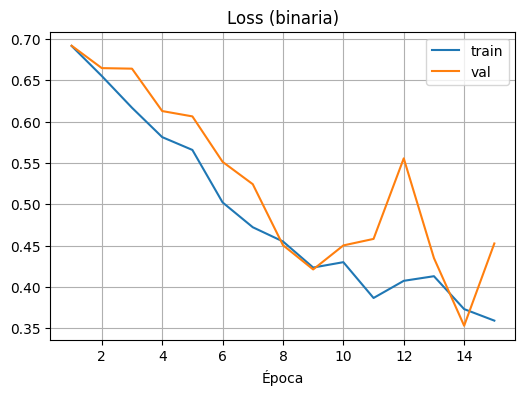

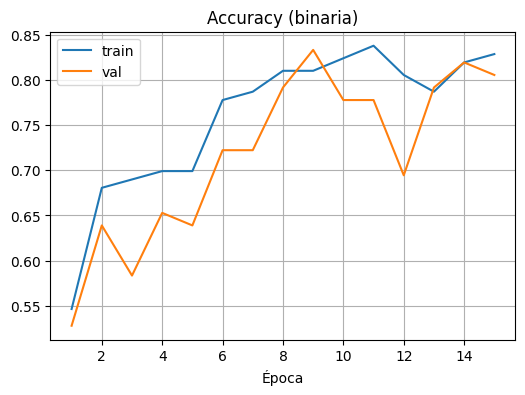

In [43]:
plt.figure(figsize=(6,4))
plt.plot(range(1,EPOCHS+1), tr_losses, label="train")
plt.plot(range(1,EPOCHS+1), va_losses, label="val")
plt.title("Loss (binaria)"); plt.xlabel("Época"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1,EPOCHS+1), tr_accs, label="train")
plt.plot(range(1,EPOCHS+1), va_accs, label="val")
plt.title("Accuracy (binaria)"); plt.xlabel("Época"); plt.grid(True); plt.legend(); plt.show()

## 3.6. Test


[TEST] loss=0.3497 | acc=84.72%
AUC: 0.932


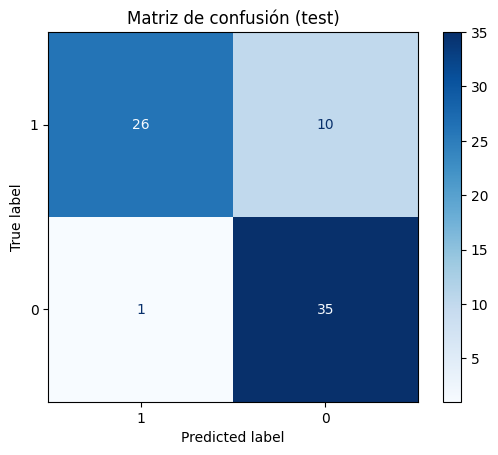

In [44]:
te_l, te_a, y_true, y_score = run_epoch(test_loader, train=False)
print(f"\n[TEST] loss={te_l:.4f} | acc={te_a*100:.2f}%")

auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.3f}")

# Matriz de confusión
y_pred = (y_score > 0.5).long()
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[CLASS_A, CLASS_B]).plot(cmap="Blues")
plt.title("Matriz de confusión (test)")
plt.show()

## 3.7. Modelo clásico.

[OK] PyTorch en cuda - Tesla T4
Clasificación binaria (solo clásico): 1 vs 0
Train: 216 | Val: 72 | Test: 72

==> Entrenamiento binario (solo clásico)
Ep 01/15 | train loss 0.6974 acc  48.1% || val loss 0.6859 acc  63.9%
Ep 02/15 | train loss 0.6670 acc  62.0% || val loss 0.6746 acc  62.5%
Ep 03/15 | train loss 0.6437 acc  56.0% || val loss 0.6647 acc  63.9%
Ep 04/15 | train loss 0.6212 acc  70.4% || val loss 0.6598 acc  63.9%
Ep 05/15 | train loss 0.6064 acc  68.5% || val loss 0.6447 acc  63.9%
Ep 06/15 | train loss 0.5614 acc  73.6% || val loss 0.6279 acc  65.3%
Ep 07/15 | train loss 0.5603 acc  75.9% || val loss 0.6284 acc  63.9%
Ep 08/15 | train loss 0.5365 acc  73.6% || val loss 0.6037 acc  68.1%
Ep 09/15 | train loss 0.5351 acc  74.5% || val loss 0.5987 acc  69.4%
Ep 10/15 | train loss 0.5105 acc  77.3% || val loss 0.5868 acc  69.4%
Ep 11/15 | train loss 0.5062 acc  74.5% || val loss 0.5689 acc  72.2%
Ep 12/15 | train loss 0.5024 acc  74.1% || val loss 0.5614 acc  69.4%
Ep 13/15 

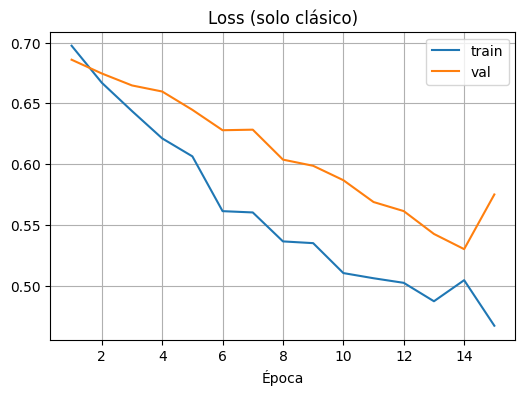

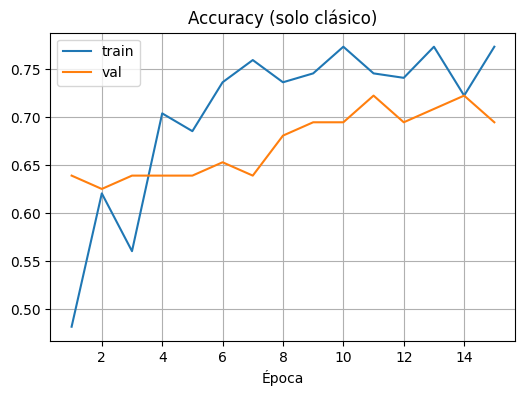


[TEST] loss=0.4278 | acc=80.56%
AUC: 0.873 | AP: 0.794


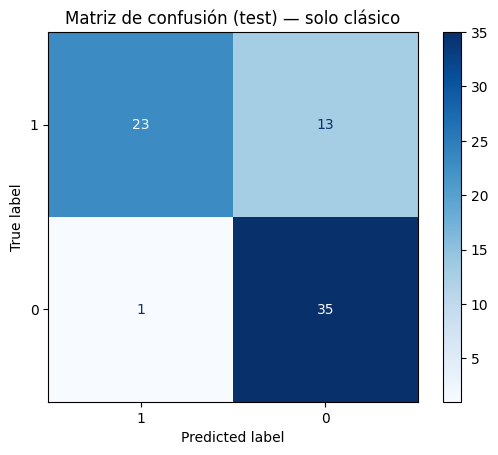

In [45]:
SEED = 87
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

assert torch.cuda.is_available(), "Activa GPU en Colab (Entorno de ejecución > Cambiar tipo > GPU)."
DEVICE = torch.device("cuda")
print("[OK] PyTorch en", DEVICE, "-", torch.cuda.get_device_name(0))

BATCH_SIZE = 32
EPOCHS     = 15
LR         = 3e-2
DROPOUT_P  = 0.30

CLASS_A, CLASS_B = 1, 0
print(f"Clasificación binaria (solo clásico): {CLASS_A} vs {CLASS_B}")

digits = load_digits()
X = torch.from_numpy(digits.images.astype(np.float32)).unsqueeze(1) / 16.0  # (N,1,8,8) en [0,1]
y = torch.from_numpy(digits.target.astype(np.int64))

# Filtrar solo las dos clases
mask = (y == CLASS_A) | (y == CLASS_B)
X, y = X[mask], y[mask]
# Remapear etiquetas: clase B -> 1, clase A -> 0
y = (y == CLASS_B).long()

# Reducción 8×8 → 2×2 (avg-pool 4×4) y aplanar a 4 features
X = F.avg_pool2d(X, kernel_size=4, stride=4).view(-1, 4)   # (N,4)

# Split 60/20/20
N   = X.shape[0]
n_tr = int(0.6*N); n_va = int(0.2*N); n_te = N - n_tr - n_va
ds_all = TensorDataset(X, y)
train_set, val_set, test_set = random_split(
    ds_all, [n_tr, n_va, n_te], generator=torch.Generator().manual_seed(SEED)
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

class ClassicalBinary(nn.Module):
    def __init__(self, p_dropout=DROPOUT_P):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64),  # ← 4 features (en el híbrido entraban 16 probs)
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 1)   # 1 logit para BCEWithLogitsLoss
        )
    def forward(self, x):
        return self.net(x.to(DEVICE)).view(-1)

model = ClassicalBinary().to(DEVICE)
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LR)

@torch.no_grad()
def eval_epoch(loader):
    model.train(False)
    total_loss, total_correct, total_count = 0.0, 0, 0
    all_y, all_s = [], []
    for xb, yb in loader:
        yb   = yb.to(DEVICE)
        logits = model(xb)  # MLP en CUDA
        loss = criterion(logits, yb.float())
        total_loss += loss.item() * xb.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        total_correct += (preds == yb).sum().item()
        total_count   += xb.size(0)
        all_y.append(yb.cpu()); all_s.append(probs.detach().cpu())
    return total_loss/total_count, total_correct/total_count, torch.cat(all_y), torch.cat(all_s)

def train_epoch(loader):
    model.train(True)
    total_loss, total_correct, total_count = 0.0, 0, 0
    for xb, yb in loader:
        yb   = yb.to(DEVICE)
        optim.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb.float())
        loss.backward()
        optim.step()
        total_loss += loss.item() * xb.size(0)
        preds = (torch.sigmoid(logits) > 0.5).long()
        total_correct += (preds == yb).sum().item()
        total_count   += xb.size(0)
    return total_loss/total_count, total_correct/total_count

tr_losses, va_losses, tr_accs, va_accs = [], [], [], []
print("\n==> Entrenamiento binario (solo clásico)")
for ep in range(1, EPOCHS+1):
    tr_l, tr_a = train_epoch(train_loader)
    va_l, va_a, _, _ = eval_epoch(val_loader)
    tr_losses.append(tr_l); va_losses.append(va_l)
    tr_accs.append(tr_a);  va_accs.append(va_a)
    print(f"Ep {ep:02d}/{EPOCHS} | train loss {tr_l:.4f} acc {tr_a*100:5.1f}% || val loss {va_l:.4f} acc {va_a*100:5.1f}%")

plt.figure(figsize=(6,4))
plt.plot(range(1,EPOCHS+1), tr_losses, label="train")
plt.plot(range(1,EPOCHS+1), va_losses, label="val")
plt.title("Loss (solo clásico)"); plt.xlabel("Época"); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(range(1,EPOCHS+1), tr_accs, label="train")
plt.plot(range(1,EPOCHS+1), va_accs, label="val")
plt.title("Accuracy (solo clásico)"); plt.xlabel("Época"); plt.grid(True); plt.legend(); plt.show()

te_l, te_a, y_true, y_score = eval_epoch(test_loader)
print(f"\n[TEST] loss={te_l:.4f} | acc={te_a*100:.2f}%")

yt = y_true.numpy()
ys = y_score.numpy()

try:
    auc = roc_auc_score(yt, ys)
except ValueError:
    auc = float("nan")
ap  = average_precision_score(yt, ys)
print(f"AUC: {auc:.3f} | AP: {ap:.3f}")

y_pred = (ys > 0.5).astype(int)
cm = confusion_matrix(yt, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[CLASS_A, CLASS_B]).plot(cmap="Blues")
plt.title("Matriz de confusión (test) — solo clásico")
plt.show()

El modelo con VQA muestra mejoría.

# Otros notebooks:
https://github.com/Bayan0708/Quantum-Machine-Learning/tree/main/03_Introduction_to_QML_Class